In [1]:
import gym
import gym_windy_gridworlds
env = gym.make('StochWindyGridWorld-v0')
# git clone https://github.com/ibrahim-elshar/gym-windy-gridworlds.git
# cd gym-windy-gridworlds
# pip install -e .

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# # of states except for terminal states
N_STATES = env.observation_space[0].n * env.observation_space[1].n

# all states
STATES = np.arange(0, N_STATES)

# possible actions
ACTIONS = [0,1,2,3]

# maximum stride for an action
STEP_RANGE = 1

def make_epsilon_greedy_policy(Q, nA, epsilon):

    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon/nA
        best_action = np.argmax(Q[observation])
        A[best_action] += ( 1.0 - epsilon)
        return A

    return policy_fn

In [2]:
T = 1000
n = 3
alpha = 0.5
sigma = 0.25
gamma = 1.0
discount_sigma = 0.9

In [3]:
def Q_sigma(env, num_episodes, sigma):
    d_sigma = False
    if sigma == -1 :
        d_sigma = True
    Q = defaultdict(lambda : np.zeros(len(ACTIONS)))
    policy = make_epsilon_greedy_policy(Q, len(ACTIONS),epsilon = 0.1)
    total_reward = [0.0]*num_episodes
    for i_episode in range(num_episodes):
        state = env.reset()
        if d_sigma :
            sigma = discount_sigma ** i_episode
        actions = []
        states = []
        deltas = []
        pis = []
        Qs = []
        ps = []
        
#         state = START_STATE[0]*10 + START_STATE[1]
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p = action_probs)
        
        states.append(state)
        actions.append(action)
        pis.append(action_probs[action])
        Qs.append(Q[state][action])
        ps.append(policy(state)[action]/policy(state)[action])
        
        # step within each episode
        final_time = 0
        for t in range(T) :
            next_state, reward ,done,_ = env.step(action)
            total_reward[i_episode] += reward
#             next_state = next_state[0]*10 + next_state[1]
            states.append(next_state)
            if done :
#                 print(t,total_reward[i_episode])
                deltas.append(reward - Q[state][action])
#                 total_reward[i_episode] /= (t+1)
            else : 
                # Select next action
                next_action_probs = policy(next_state)
                next_action = np.random.choice(np.arange(len(next_action_probs)), p = next_action_probs)

                # Store
                actions.append(next_action)
                Qs.append(Q[next_state][next_action])
                pis.append(policy(next_state)[next_action])
                V_next = next_action_probs[0] * Q[next_state][0] + next_action_probs[1] * Q[next_state][1] + next_action_probs[2] * Q[next_state][2] + next_action_probs[3] * Q[next_state][3]
                deltas.append(reward + gamma*(sigma*Q[next_state][next_action] + (1-sigma)*V_next) - Q[state][action])
                action = next_action
                state = next_state
                ps.append(policy(next_state)[next_action]/policy(next_state)[next_action])
            # Update within each step
            tau = t - n + 1
            if tau >= 0:
                p = 1.0
                E = 1.0
                G = Q[states[tau]][actions[tau]]
                for k in range(tau,t+1):
                    G = G + E*deltas[k]
                    E = gamma*E*((1-sigma)*pis[k] + sigma)
                    p = p*(1-sigma + sigma*ps[k])
                Q[states[tau]][actions[tau]] += alpha*p*(G - Q[states[tau]][actions[tau]])
            if done :
                break
        for i in range(t-n+1,t+1):
            p = 1.0
            E = 1.0
            G = Q[states[i]][actions[i]]
            for k in range(i,t+1):
                G = G + E*deltas[k]
                E = gamma*E*((1-sigma)*pis[k] + sigma)
                p = p*(1-sigma + sigma*ps[k])
#                 print(i,k,len(deltas))
            Q[states[i]][actions[i]] += alpha*p*(G - Q[states[i]][actions[i]])
            
#         print(i_episode,total_reward[i_episode])
    return total_reward

In [7]:
return_1 = []
for k in range(10):
    alpha = 0.1*k
    total_reward_1 = Q_sigma(env,1000,1)
    ans = 0.0
    for i in range(len(total_reward_1)) :
        ans += total_reward_1[i]
    ans /= len(total_reward_1)
    return_1.append(ans)
    print(0.1*k,ans)

0.0 -998.917
0.1 -40.271
0.2 -41.72
0.30000000000000004 -50.771
0.4 -57.826
0.5 -81.898
0.6000000000000001 -116.12
0.7000000000000001 -141.995
0.8 -618.845


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars


0.9 -751.347


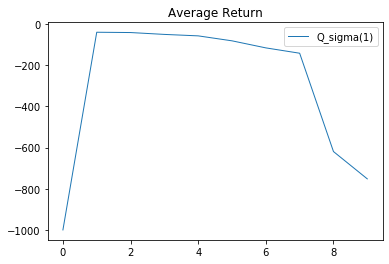

In [9]:
df=pd.DataFrame({'x': range(len(return_1)),
                 'Q_sigma(1)': return_1
                })
plt.figure()
plt.title('Average Return')
plt.plot( 'x', 'Q_sigma(1)', data=df, linewidth=1, label="Q_sigma(1)")
plt.legend()